# Khai báo thư viện

In [114]:
%pip install numpy
%pip install os
%pip install opencv-contrib-python
%pip install matplotlib
%pip install tensorflow
%pip install random
%pip install warnings
%pip install keras
%pip install scikit-learn
%pip install imutils

^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
from imutils import paths
from keras.layers import Dense, Flatten, Dropout, Input, AveragePooling2D
from sklearn.model_selection import train_test_split
from keras.applications import MobileNetV3Large
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer

# Chuẩn bị dữ liệu

In [6]:
imagePaths = sorted(list(paths.list_images("fruq")))

random.seed(42)
random.shuffle(imagePaths)

data = []
labels = []

for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (224, 224))
    image = img_to_array(image)
    data.append(image)
    
    
    label1 = imagePath.split(os.path.sep)[-2]
    label2 = imagePath.split(os.path.sep)[-3]
    labels.append([label1, label2])
    
data = np.array(data, dtype="float") / 255.0
print("{} hình ảnh ({:.2f}MB)".format(len(imagePaths), data.nbytes / (1024 * 1000.0)))

2032 hình ảnh (2389.63MB)


In [7]:
labels = np.array(labels)
print(data.shape)

(2032, 224, 224, 3)


In [8]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
print("class labels:")
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, label))


class labels:
1. Banana
2. Cucumber
3. Good
4. Grape
5. Mild
6. Rotten


In [9]:
mlb.classes_

array(['Banana', 'Cucumber', 'Good', 'Grape', 'Mild', 'Rotten'],
      dtype=object)

In [10]:
X_train, X_test, y_train, y_test= train_test_split(data, labels, test_size = 0.2, random_state = 42)

# Mô hình 

In [11]:
from tensorflow.keras.models import Model

INPUT_SHAPE = (224, 224, 3)
N_CLASSES = 6

class FruQNet(object):
    @staticmethod
    def build(inputs, classes = N_CLASSES):
        base = MobileNetV3Large(input_tensor=Input(shape=inputs), include_top=False)
        for layer in base.layers[:-4]:
            layer.trainable = False
        
        inpt = Input(shape=inputs)
        x = base (inpt)
        x = AveragePooling2D(pool_size=(2,2)) (x)
        x = Flatten() (x)
        x = Dense(512, activation='relu') (x)
        x = Dropout(0.5) (x)
        x = Dense(50, activation='relu') (x)
        x = Dropout(0.5) (x)
        
        x = Dense(classes, activation='sigmoid', name='fruit')(x)
        model = Model(inputs=[inpt], outputs=[x])
        return model
    


model = FruQNet.build(INPUT_SHAPE)

In [12]:
model.compile(loss= "binary_crossentropy", 
              metrics=["accuracy"], optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001))

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 average_pooling2d (Average  (None, 3, 3, 960)         0         
 Pooling2D)                                                      
                                                                 
 flatten (Flatten)           (None, 8640)              0         
                                                                 
 dense (Dense)               (None, 512)               4424192   
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

image_aug = ImageDataGenerator(rotation_range=25, 
                         width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.2, zoom_range=0.2,
	                       horizontal_flip=True, fill_mode="nearest")

# Quá trình huấn luyện

In [15]:
hist = model.fit(image_aug.flow(X_train, y_train, batch_size = 32), 
                 steps_per_epoch = len(X_train) // 32,	
                 validation_data = (X_test, y_test),	
                 validation_steps = len(X_test) // 32, 
                 epochs = 50, verbose = 1)

Epoch 1/50
50/50 [==============================] - 43s 760ms/step - loss: 0.6112 - accuracy: 0.3823 - val_loss: 0.3915 - val_accuracy: 0.8968
Epoch 2/50
50/50 [==============================] - 42s 847ms/step - loss: 0.4494 - accuracy: 0.6899 - val_loss: 0.3058 - val_accuracy: 0.8968
Epoch 3/50
50/50 [==============================] - 47s 939ms/step - loss: 0.4066 - accuracy: 0.7677 - val_loss: 0.3019 - val_accuracy: 0.8968
Epoch 4/50
50/50 [==============================] - 45s 904ms/step - loss: 0.3620 - accuracy: 0.8173 - val_loss: 0.2648 - val_accuracy: 0.8968
Epoch 5/50
50/50 [==============================] - 39s 777ms/step - loss: 0.3406 - accuracy: 0.8311 - val_loss: 0.2645 - val_accuracy: 0.8968
Epoch 6/50
50/50 [==============================] - 32s 642ms/step - loss: 0.3229 - accuracy: 0.8311 - val_loss: 0.2332 - val_accuracy: 0.8968
Epoch 7/50
50/50 [==============================] - 43s 866ms/step - loss: 0.3156 - accuracy: 0.8249 - val_loss: 0.2282 - val_accuracy: 0.8968

In [16]:
loss, accuracy = model.evaluate(X_test, y_test) # Đánh giá mô hình
print("Hàm mất mát:", loss)
print("Độ chính xác:", accuracy)

13/13 [==============================] - 6s 427ms/step - loss: 0.1497 - accuracy: 0.8968
Hàm mất mát: 0.1496807038784027
Độ chính xác: 0.8968058824539185


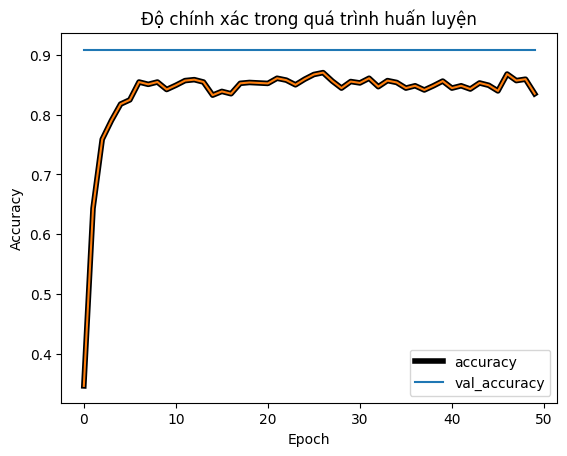

In [140]:
plt.figure()
plt.plot(hist.history['accuracy'], label = 'accuracy', linewidth=4, color='black')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc="lower right")
plt.plot(hist.history['accuracy'], label = 'accuracy')
plt.title("Độ chính xác trong quá trình huấn luyện")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

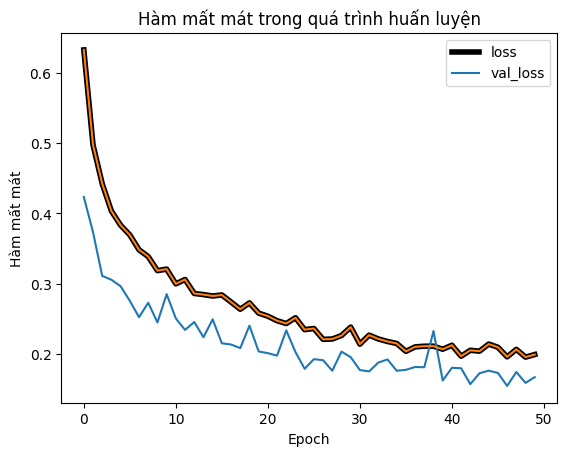

In [141]:
plt.figure()
plt.plot(hist.history['loss'], label = 'loss', linewidth=4, color='black')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.legend(loc="upper right")
plt.plot(hist.history['loss'], label = 'loss')
plt.title("Hàm mất mát trong quá trình huấn luyện")
plt.xlabel("Epoch")
plt.ylabel("Hàm mất mát")
plt.show()

# Dự đoán nhãn dữ liệu

1/1 [==============================] - 0s 50ms/step


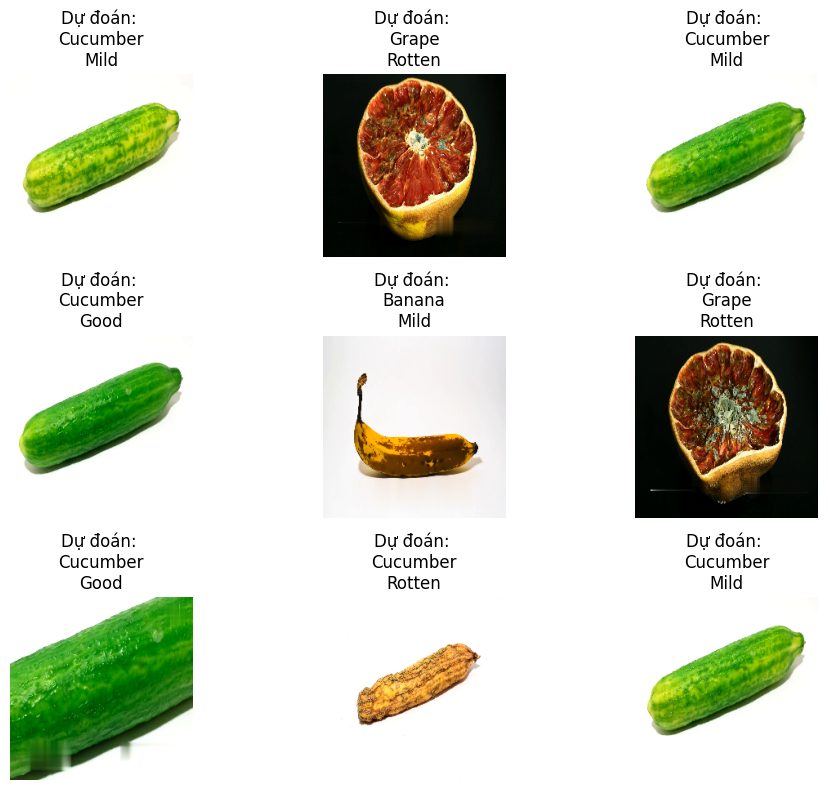

In [22]:

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8)) # 9 hình ảnh từ tập thử cho 3 dòng, 3 cột
axes = axes.flatten()
labels = []

for img, ax in zip(X_test, axes):
    img = cv2.cvtColor(img.astype('float32'), cv2.COLOR_RGB2BGR)
    
    prob = model.predict(np.expand_dims(img, axis=0))[0]
    # Trích ra 2 xác suất cao nhất
    argmax = np.argsort(prob)[::-1][:2]
    for (i, j) in enumerate(argmax):
      # popup nhãn và xác suất dự báo lên ảnh hiển thị
      label = "{}".format(mlb.classes_[j])
      labels.append(label)
      if len(labels) == 2:
        ax.set_title(f"Dự đoán: \n{labels[0]}\n{labels[1]}")
        labels = []
        
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 54ms/step


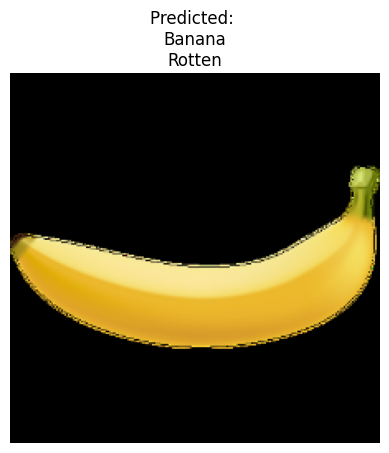

In [31]:
img = 'bana.png'

def predict_image(img):
    labels = []
    
    ###### Quá trình tiền xử lý dữ liệu
    image = cv2.imread(img)
    image = cv2.resize(image, (224, 224))
    image = img_to_array(image)
    image = np.array(image, dtype="float") / 255.0
    image = cv2.cvtColor(image.astype('float32'), cv2.COLOR_RGB2BGR)
    ###### Dự doán
    prob = model.predict(np.expand_dims(image, axis=0))[0]
    argmax = np.argsort(prob)[::-1][:2]
    labels = [mlb.classes_[j] for _, j in enumerate(argmax)]
    plt.title(f"Predicted: \n{labels[0]}\n{labels[1]}")
        
    plt.imshow(image, cmap='gray')
    plt.axis('off')

predict_image(img)
plt.show()

In [144]:
import pickle

pickle.dump(model, open('flask/model.pkl', 'wb'))